In [7]:
%matplotlib inline
import numpy as np
from scipy import io, signal
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def beg_end(spikes_all):
    spikes_concat = np.concatenate(spikes_all)
    return np.floor(spikes_concat.min()), np.ceil(spikes_concat.max())

In [97]:
datafolder = '/Users/rdgao/Documents/data/Stringer_neuropixel/spikes/'
mice = ['Krebs', 'Waksman', 'Robbins']
cluLocs = io.loadmat(datafolder+'cluLoc.mat', squeeze_me = True)
probe_id = cluLocs['iprobeAll']
probe_loc = cluLocs['brainLocNameAll']

In [213]:
bin_width = 0.01
i_m = 1
mouse = mice[i_m]
mouse_data = io.loadmat(datafolder+'spks/spks%s_Feb18.mat'%mouse, squeeze_me = True)['spks']
clu_info = pd.DataFrame(np.array([probe_id[i_m],probe_loc[i_m]]).T, columns=['probe', 'region'])

In [214]:
print('Grab Spikes')
spikes_all = []
for probe in range(len(mouse_data)):
    st = mouse_data[probe][0]
    clu = mouse_data[probe][1]
    # add spike time into each
    spikes_all += [np.sort(st[clu==k]) for k in np.unique(clu)]

print('Bin Spikes')
t_beg, t_end = beg_end(spikes_all)
t_bins = np.arange(t_beg,t_end,bin_width)
spk_binned = [np.histogram(spks,t_bins)[0] for spks in spikes_all]
df_spk = pd.DataFrame(np.array(spk_binned).T, index=t_bins[:-1])

Grab Spikes
Bin Spikes


In [47]:
datafolder = '/Users/rdgao/Documents/data/Stringer_neuropixel/spikes/'    
def load_mouse_data(datafolder, i_m, return_type='binned', bin_width=0.01, smooth_param=[0.2, 0.025]):
    mice = ['Krebs', 'Waksman', 'Robbins']
    cluLocs = io.loadmat(datafolder+'cluLoc.mat', squeeze_me = True)
    probe_id = cluLocs['iprobeAll']
    probe_loc = cluLocs['brainLocNameAll']
    
    # load data and cluster info
    mouse_data = io.loadmat(datafolder+'spks/spks%s_Feb18.mat'%mice[i_m], squeeze_me = True)['spks']
    clu_info = pd.DataFrame(np.array([probe_id[i_m],probe_loc[i_m]]).T, columns=['probe', 'region'])
    
    print('Grabbing Spikes...')
    spikes_all = []
    for probe in range(len(mouse_data)):
        st = mouse_data[probe][0]
        clu = mouse_data[probe][1]
        # add spike time into each
        spikes_all += [np.sort(st[clu==k]) for k in np.unique(clu)]
    
    if return_type is 'spiketimes': 
        return spikes_all, clu_info
    
    print('Binning Spikes...')
    t_beg, t_end = beg_end(spikes_all)
    t_bins = np.arange(t_beg,t_end,bin_width)
    spk_binned = [np.histogram(spks,t_bins)[0] for spks in spikes_all]
    df_spk = pd.DataFrame(np.array(spk_binned).T, index=t_bins[:-1])

    if return_type is 'binned':
        return df_spk, clu_info
    
    if return_type is 'smoothed':
        print('Smoothing...')
        win = signal.windows.gaussian(int(win_len/bin_width)+1, win_std/bin_width)
        win/=win.sum()
        bin_smoothed = signal.convolve(df_spk, win[:,None], mode='same')
        df_spk_smo = pd.DataFrame(bin_smoothed, index=t_bins[:-1])
        return df_spk_smo, clu_info

In [70]:
df_spk50, df_info = load_mouse_data(datafolder, 0, return_type='binned', bin_width=0.05)
df_spk10, df_info = load_mouse_data(datafolder, 0, return_type='binned', bin_width=0.01)
df_spk5, df_info = load_mouse_data(datafolder, 0, return_type='binned', bin_width=0.005)

Grabbing Spikes...
Binning Spikes...
Grabbing Spikes...
Binning Spikes...
Grabbing Spikes...
Binning Spikes...


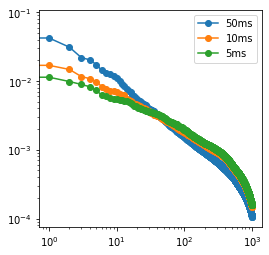

In [73]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1000)
plt.figure(figsize=(4,4))
spk_proj = pca.fit_transform(df_spk50.values)
plt.loglog(pca.explained_variance_ratio_, 'o-', label='50ms')
spk_proj = pca.fit_transform(df_spk10.values)
plt.loglog(pca.explained_variance_ratio_, 'o-', label='10ms')
spk_proj = pca.fit_transform(df_spk5.values)
plt.loglog(pca.explained_variance_ratio_, 'o-', label='5ms')
plt.legend()

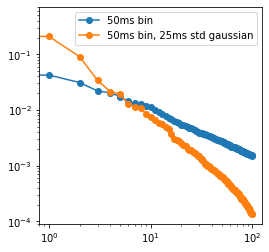

In [67]:

plt.loglog(var, 'o-')
plt.loglog(pca.explained_variance_ratio_, 'o-')
plt.legend(['50ms bin', '50ms bin, 25ms std gaussian'])
#plt.plot(np.cumsum(pca.explained_variance_ratio_), 'o-')

